In [2]:
from ModelSchema.NeuralNetWork import dataset, train_and_test, model

import pandas as pd
import os
from torch.utils.data import DataLoader
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from torchvision import models
from torchinfo import summary
from torchvision import transforms

test = dataset.SpectraDataset('../database/spectras/test')
loader_test = DataLoader(test, batch_size= 32, pin_memory= True, shuffle=True)

model = torch.load('../models/trained_models/mobilenet_200.pth')
autoencoder = torch.load('../models/trained_models/autoencoder.pth')


/tmp/ipykernel_113111/4258229474.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('../models/trained_models/mobilenet_200.pth')
/tmp/ipykernel_113111/

In [3]:
def stft(spectra: torch.tensor ) -> torch.tensor:
        
        interferogram = interferogramFunc(signal = spectra)

        result = torch.stft(interferogram, n_fft = 2048, return_complex = True, normalized = True, window=torch.hann_window(2048, device='cpu'))
        magnitude = torch.abs(result)
        
        # Verificar se existem valores negativos ou NaNs no emagnitudea original
        if torch.any(magnitude < 0):
            print("Aviso: Valores negativos detectados na magnitude!")
        if torch.any(torch.isnan(magnitude)):
            print("Aviso: Valores NaN detectados na magnitude!")

        # Evitar log(0) adicionando epsilon
        magnitude_clamped = torch.clamp(magnitude, min=1e-14)

        # Converter para decibéis
        magnitude_db = 20 * torch.log10(magnitude_clamped)

        # Verificar se o cálculo gerou NaN ou Inf
        if torch.any(torch.isnan(magnitude_db)):
            print("Aviso: Valores NaN detectados após conversão para dB!")
        if torch.any(torch.isinf(magnitude_db)):
            print("Aviso: Valores infinitos detectados após conversão para dB!")

        # Substituir NaNs e Infinitos por 0
        magnitude_db = torch.nan_to_num(magnitude_db, nan=0.0, posinf=0.0, neginf=0.0)

        return magnitude_db, interferogram

def interferogramFunc(signal: np.array) -> np.array:
        
        interferogram = torch.fft.ifft(signal)

        interferogram = torch.fft.ifftshift(interferogram)


        return interferogram

hcl_20_20c_398mbar.csv


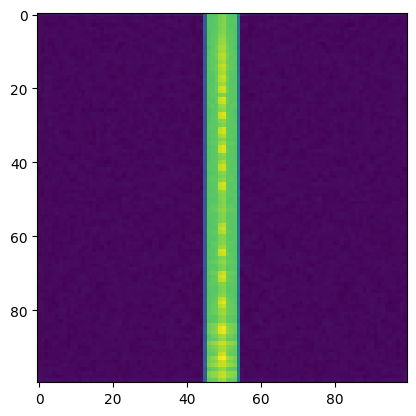

(tensor(55.6729, grad_fn=<SubBackward0>),
 tensor(800.7663, grad_fn=<MulBackward0>))

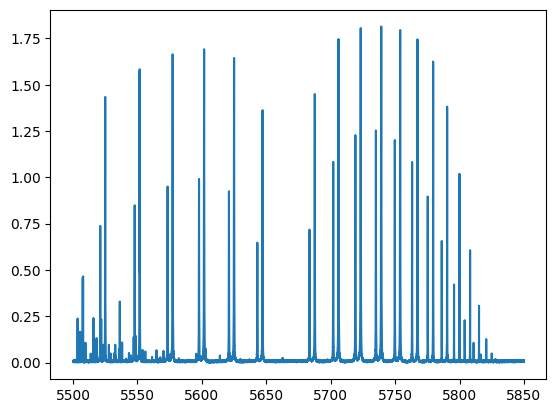

In [12]:

real_spectras = os.listdir('../database/real_spectras')
spec = real_spectras[int(np.random.uniform(0,14))]
print(spec)
real_spectra = pd.read_csv(f'../database/real_spectras/{spec}')


real_spectra = real_spectra[real_spectra['LinePosition(cm-1)'] > 5500]

spectra = torch.tensor(real_spectra['Intensity'],dtype=torch.float)

spectrogram, interferogram = stft(spectra = spectra)

resize = transforms.Resize((100,100))

spectrogram = spectrogram.unsqueeze(0)

spectrogram = resize(spectrogram)


plt.imshow(spectrogram.squeeze(0))
plt.show()
plt.plot(real_spectra['LinePosition(cm-1)'],real_spectra['Intensity'])

  

pred = model(spectrogram.unsqueeze(0))

pred[0][0]*(373.15-273.15) + 273.15 - 273.1, (pred[0][1]* (1- 0.01) + 0.01) * 1013

(tensor(37.2874, grad_fn=<SubBackward0>),
 tensor(253.1909, grad_fn=<MulBackward0>))

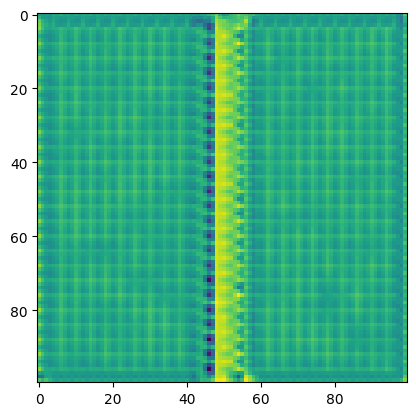

In [13]:
spec = autoencoder(spectrogram.unsqueeze(0))

pred = model(spec)

spec = spec.squeeze(0).detach().numpy()

plt.imshow(spec.squeeze(0))

pred[0][0]*(373.15-273.15) + 273.15 - 273.1, (pred[0][1]* (1- 0.01) + 0.01) * 1013

In [7]:
spectrogram.shape

torch.Size([1, 100, 100])

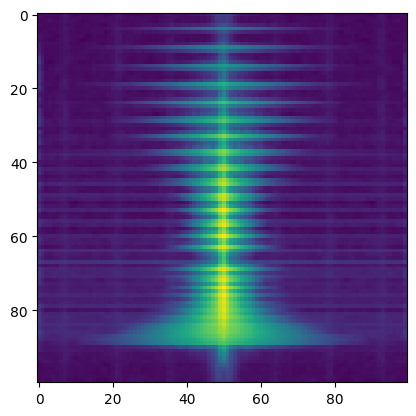

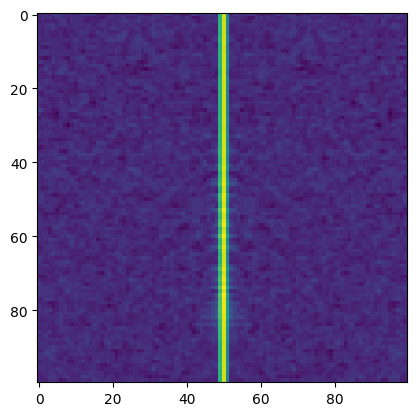

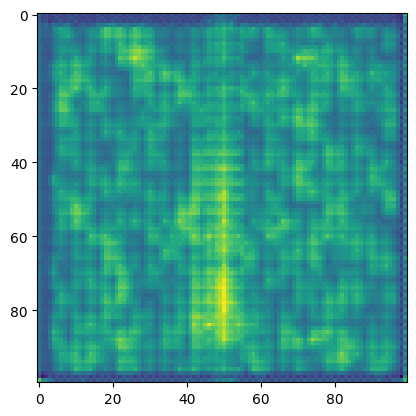

In [28]:
X , env, X_noise = test[int(np.random.uniform(0,200))]

#print(X)
model.eval()
with torch.no_grad():
    #pred = model(X)
    X_denoise = autoencoder(X_noise.unsqueeze(0))

s = X.squeeze(0).numpy()
s_denoise = X_denoise.squeeze(0).numpy()
plt.imshow(s)
plt.show()
plt.imshow(X_noise.squeeze(0).numpy())
plt.show()
plt.imshow(s_denoise.squeeze(0))
plt.show()

In [25]:
X.shape

torch.Size([1, 100, 100])

In [14]:
env[0] *(373.15-273.15) + 273.15 , pred[0][0]*(373.15-273.15) + 273.15

(tensor(317.1117), tensor(312.7200))

In [15]:
env[1] * (1- 0.01) + 0.01 , pred[0][1]* (1- 0.01) + 0.01

(tensor(0.6065), tensor(0.6629))